In [54]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
titanic = pd.read_csv('./Titanic.csv')

# Display the first few rows of the dataframe
titanic.head()

,Unnamed: 0,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1st,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.337494,B5,Southampton,2,NaN,"St Louis, MO"
1,2,1st,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.550003,C22 C26,Southampton,11,NaN,"Montreal, PQ / Chesterville, ON"
2,3,1st,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,4,1st,0,"Allison, Mr. Hudson Joshua Crei",male,30.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,5,1st,0,"Allison, Mrs. Hudson J C (Bessi",female,25.0000,1,2,113781,151.550003,C22 C26,Southampton,NaN,NaN,"Montreal, PQ / Chesterville, ON"


# Step 1

In [55]:
def QuantileBinning(feature, bin_number):
    """
    This function takes a numerical feature and the number of bins, and
    returns the feature binned into quantile-based bins.

    Parameters:
    - feature (pandas.Series): The numerical feature to be binned.
    - bin_number (int): The number of quantile bins.

    Returns:
    - pandas.Series: A series of discrete features binned by quantile.
    """
    # Use qcut to create quantile-based bins for the feature
    # If there are fewer unique values than bins, qcut could throw an error.
    # 'duplicates' parameter handles this by dropping redundant bins.
    return pd.qcut(feature, q=bin_number, labels=False, duplicates='drop')


def label_encoder(feature):
    unique_labels = pd.unique(feature)
    label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
    transformed_feature = np.array([label_to_int[label] for label in feature])
    return transformed_feature

print(titanic.columns)

Index(['Unnamed: 0', 'pclass', 'survived', 'name', 'sex', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked', 'boat', 'body',
       'home.dest'],
      dtype='object')


In [56]:
# Fill missing values in 'age' with the average age
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
titanic['age'] = imputer.fit_transform(titanic[['age']])

# Discretization
titanic['age'] = QuantileBinning(titanic['age'], bin_number=4)
training = titanic[['pclass', 'sex', 'age', 'sibsp', 'survived']]
training['sex'] = label_encoder(training['sex'])
training.head()


# Split the data into 80% training and 20% test sets
from sklearn.model_selection import train_test_split
X = training.drop('survived', axis=1)  # Features
y = training['survived']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [57]:
training.head()

,pclass,sex,age,sibsp,survived
0,1st,0,1,0,1
1,1st,1,0,1,1
2,1st,0,0,1,0
3,1st,1,2,1,0
4,1st,0,1,1,0


# Step 2

In [58]:
# define your entropy function and information gain function
def entropy(labels):
    # Calculate the frequency of each label
    unique_labels, counts = np.unique(labels, return_counts=True)
    
    # Probability of each label
    probabilities = counts / len(labels)
    
    # Calculate the entropy using the formula: -sum(p * log2(p))
    entropy_value = -np.sum(probabilities * np.log2(probabilities))
    return entropy_value
# Calculate Information Gain for each feature in the training set
def information_gain(data, feature, target):
    # Calculate the entropy of the entire dataset (before the split)
    total_entropy = entropy(target)
    
    # Get the unique values of the feature (for splitting)
    unique_values = np.unique(data[feature])
    
    # Calculate the weighted entropy after the split based on the feature
    weighted_entropy = 0
    for value in unique_values:
        subset = target[data[feature] == value]
        weighted_entropy += (len(subset) / len(target)) * entropy(subset)
    
    # Information gain is the reduction in entropy after the split
    return total_entropy - weighted_entropy

In [59]:
# Define the features to check (excluding 'survived' as it's the target)
features = ['pclass', 'sex', 'age', 'sibsp']
info_gains = {}
for feature in features:
    info_gains[feature] = information_gain(X_train, feature, y_train)
    
info_gains

{'pclass': np.float64(0.06353574221838065),
 'sex': np.float64(0.20968297666244173),
 'age': np.float64(0.007770445160818706),
 'sibsp': np.float64(0.02531230300308862)}

So the first split should be "sex"

# Step 3

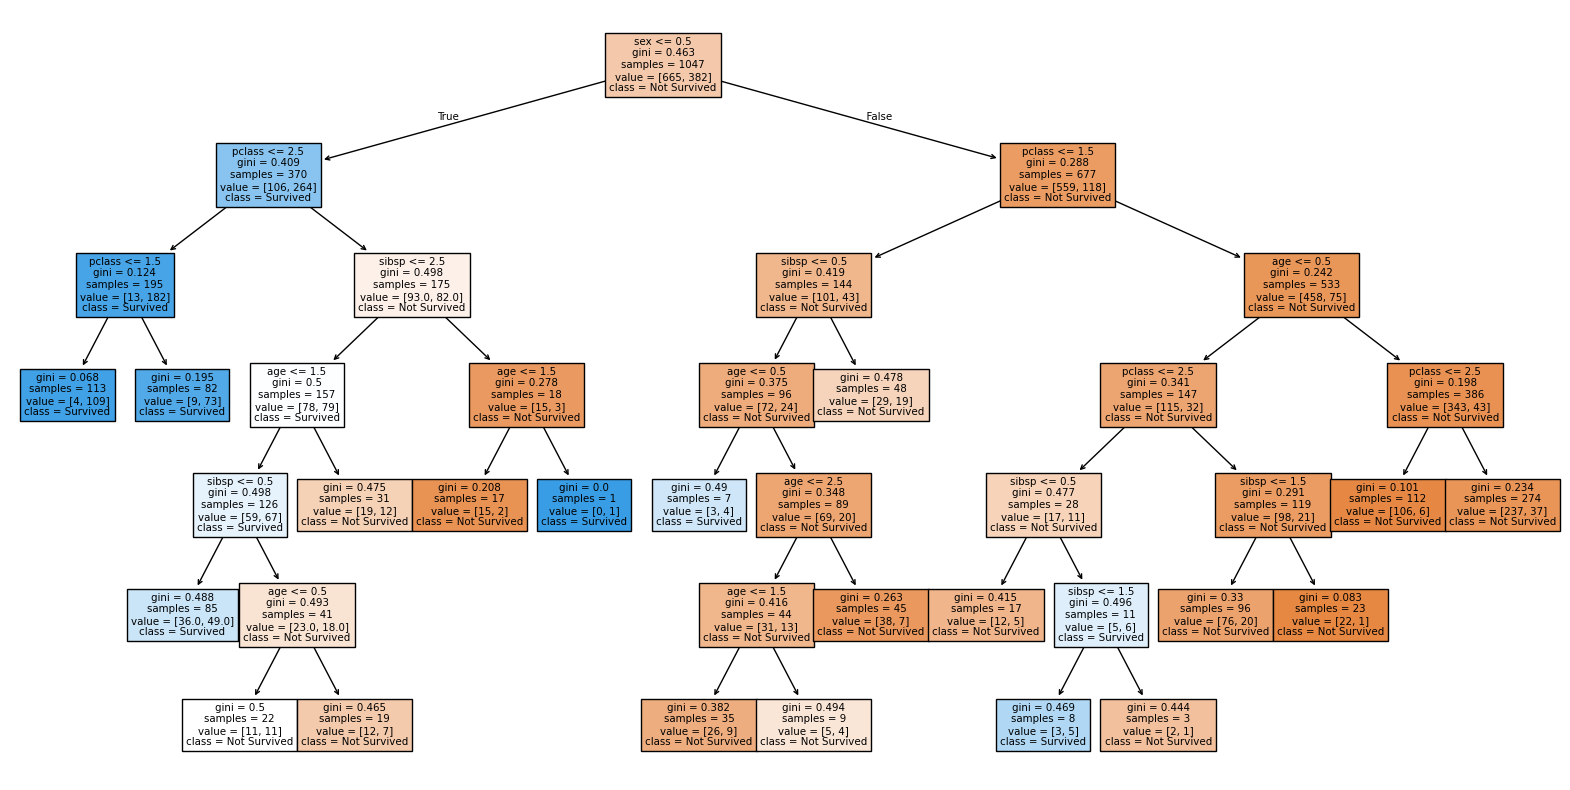

In [60]:
from sklearn.tree import DecisionTreeClassifier, plot_tree #sklearn.metrics is not imported !!!

# Instantiate the DecisionTreeClassifier
student_id = 20006584  
dt = DecisionTreeClassifier(max_leaf_nodes=20, random_state=student_id)

# Prepare the features and target variables for training
# set in step 1

###
# The following code was added due to an error with pclass. To resolve the error, the code was added to convert the pclass column to an int by taking the first character of the string.
def convert_pclass(p):
    if isinstance(p, str):
        return int(p[0])
    return p
# Apply the conversion to the 'pclass' column in the training set.
X_train['pclass'] = X_train['pclass'].apply(convert_pclass)
X_test['pclass'] = X_test['pclass'].apply(convert_pclass)
###

# Fit the decision tree model
dt.fit(X_train, y_train)

# Plot the full decision tree
plt.figure(figsize=(20,10))
plot_tree(dt, filled=True, feature_names=X_train.columns, class_names=['Not Survived', 'Survived'])
plt.show()



In [61]:
# Define your performance metrics including accuracy, precision, recall and F1-scorre
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred)
    }
    return metrics

performance_metrics = evaluate_model(dt, X_test, y_test)
print(performance_metrics)

{'Accuracy': 0.7557251908396947, 'Precision': 0.8375, 'Recall': 0.5677966101694916, 'F1 Score': 0.6767676767676768}


# Step 4

Optimal max_leaf_nodes: 6


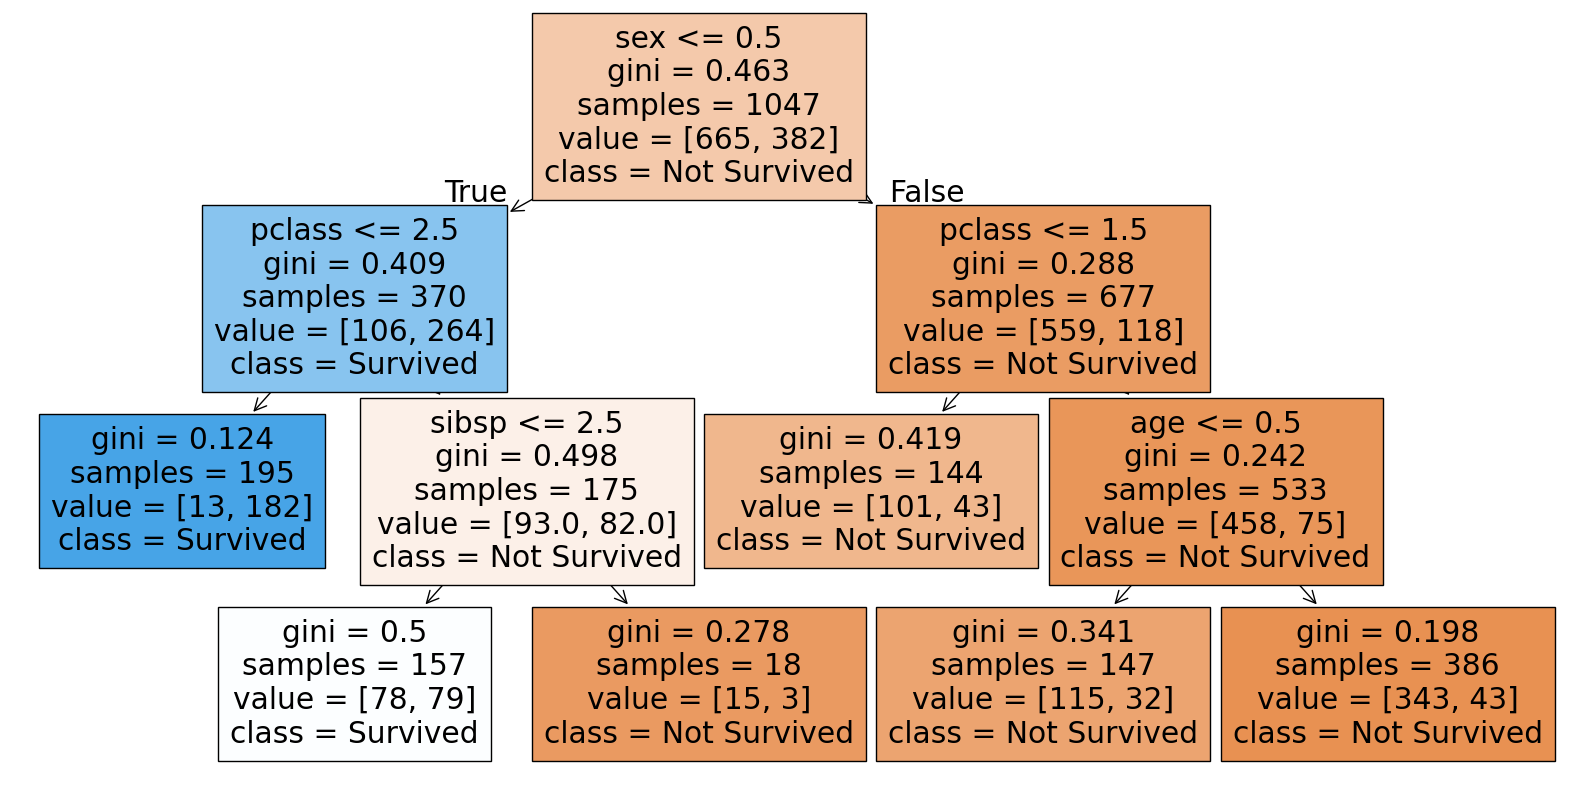

In [62]:
from sklearn.model_selection import GridSearchCV

# Define a range of max_leaf_nodes values to search
param_grid = {'max_leaf_nodes': list(range(5, 20))}

# Run grid search with cross-validation
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train) # Note testing set cannot be used

# Get the best estimator with the optimal max_leaf_nodes parameter
dt_pruned = grid_search.best_estimator_
print("Optimal max_leaf_nodes:", grid_search.best_params_['max_leaf_nodes'])


# Plot the pruned decision tree
plt.figure(figsize=(20,10))
plot_tree(dt_pruned, filled=True, feature_names=X_train.columns, class_names=['Not Survived', 'Survived'])
plt.show()


# Step 5


In [63]:
## it's an example (max_depth)

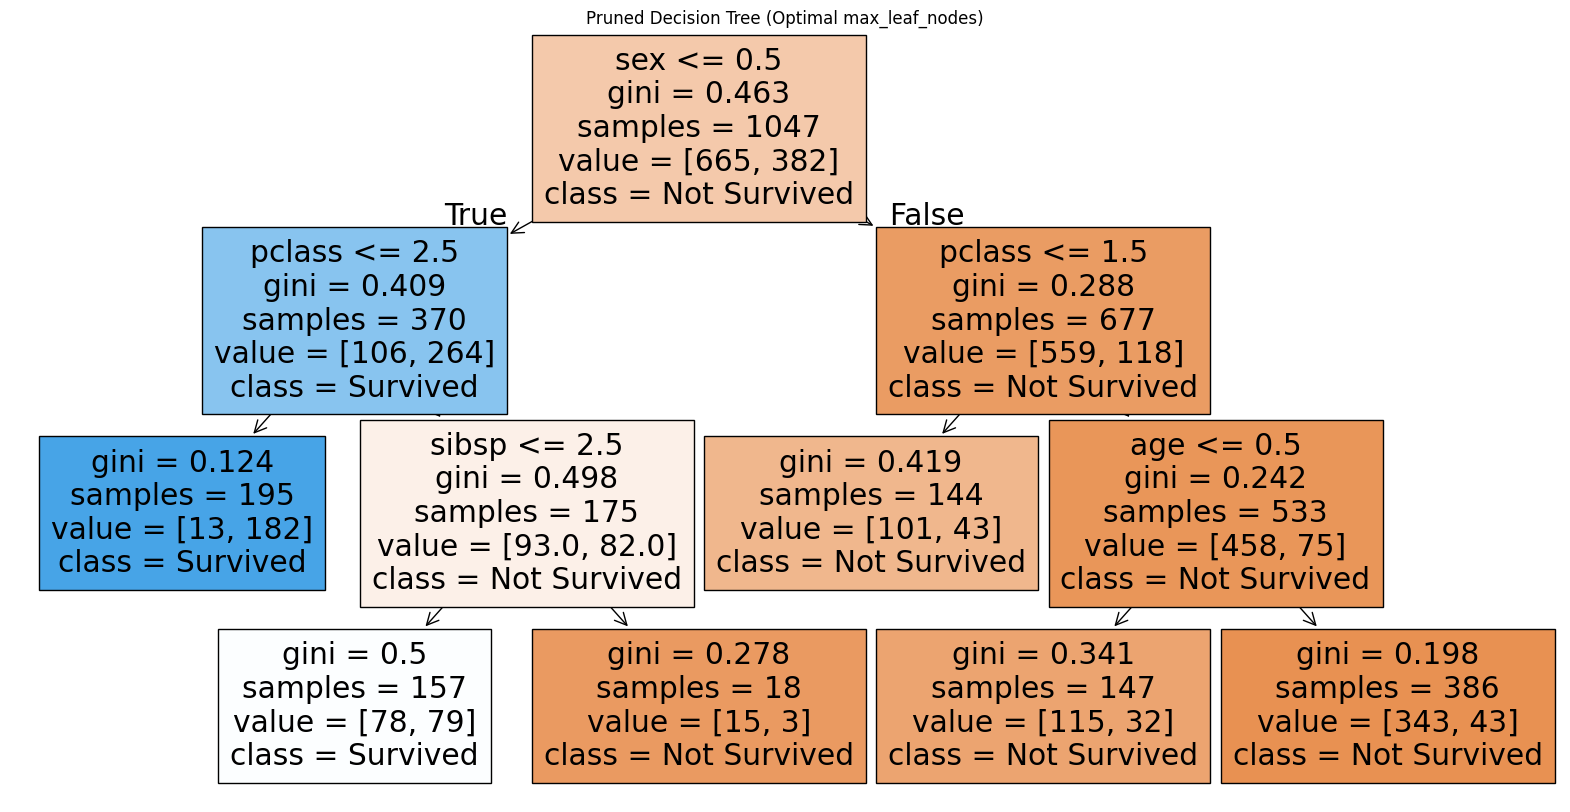

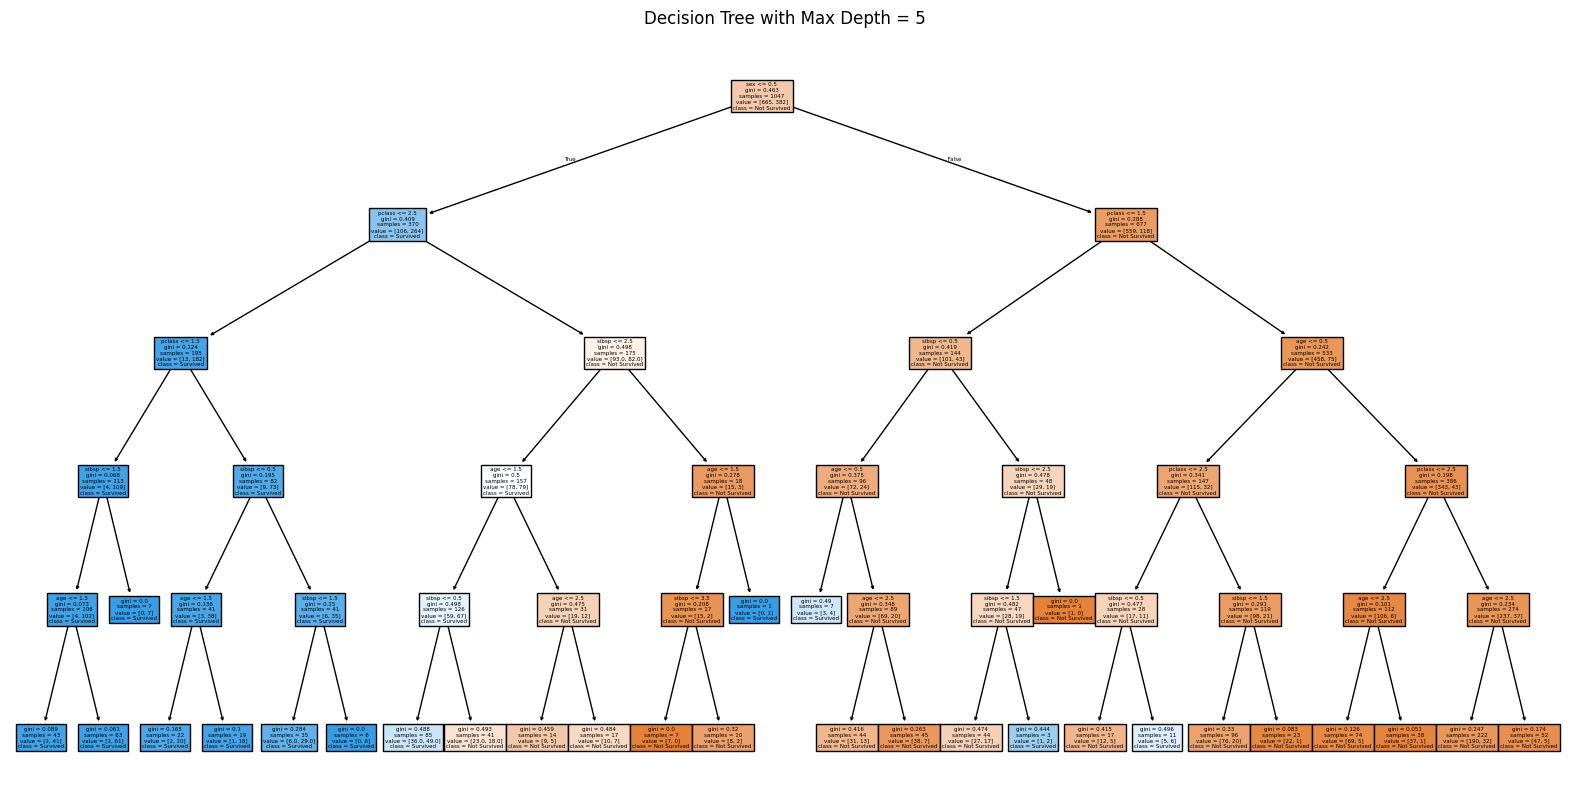

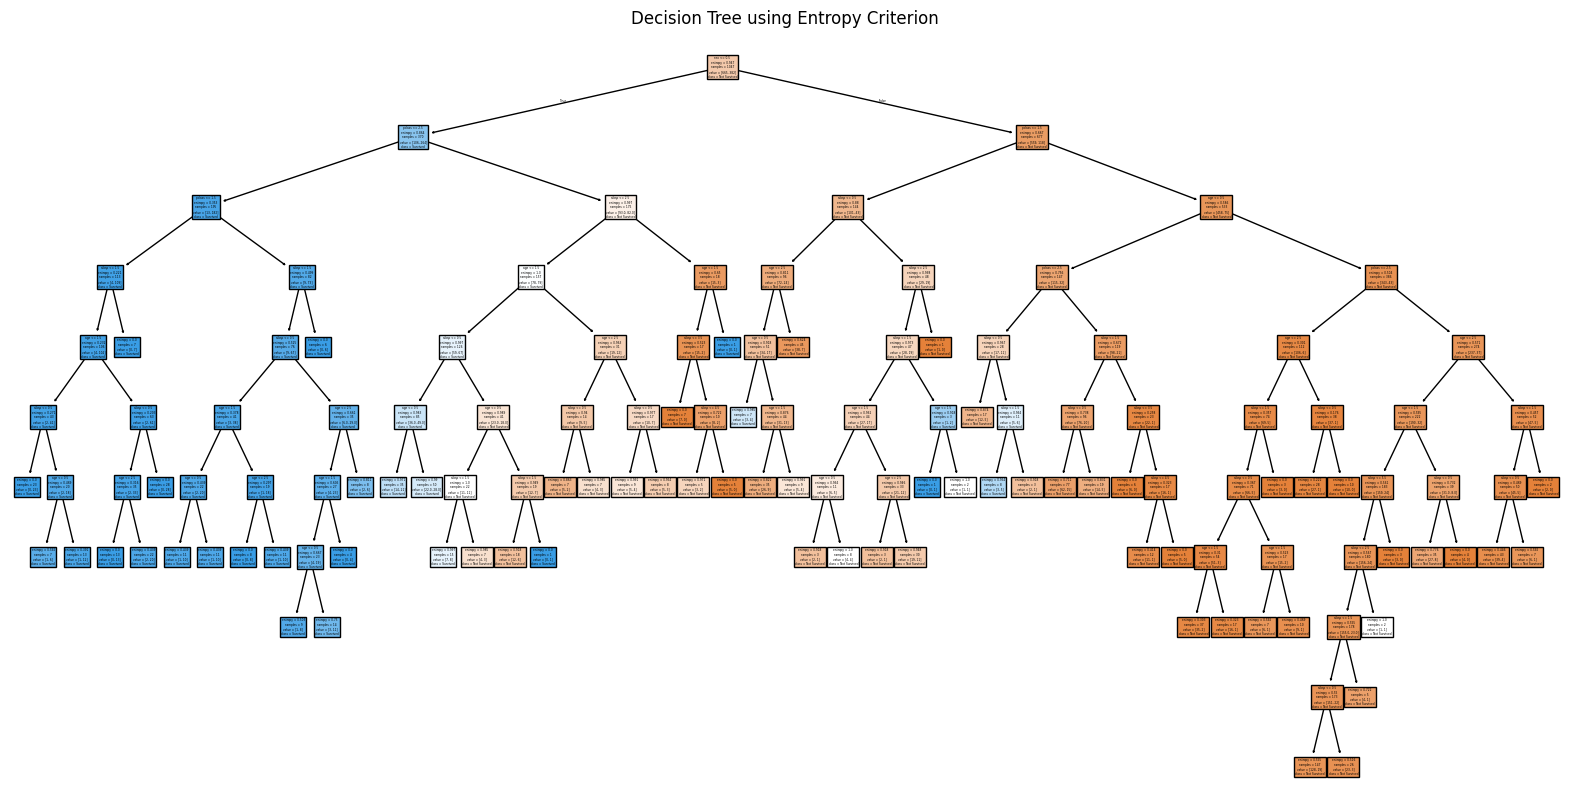

In [64]:
from sklearn.ensemble import RandomForestClassifier
# New model 1: Decision Tree with a maximum depth constraint
dt_max_depth = DecisionTreeClassifier(max_depth=5, random_state=student_id)
dt_max_depth.fit(X_train, y_train)

# New model 2: Decision Tree using entropy instead of the default 'gini')
dt_entropy = DecisionTreeClassifier(criterion='entropy', random_state=student_id)
dt_entropy.fit(X_train, y_train)    

plt.figure(figsize=(20,10))
plot_tree(dt_pruned, filled=True, feature_names=X_train.columns, class_names=['Not Survived', 'Survived'])
plt.title("Pruned Decision Tree (Optimal max_leaf_nodes)")
plt.show()

plt.figure(figsize=(20,10))
plot_tree(dt_max_depth, filled=True, feature_names=X_train.columns, class_names=['Not Survived', 'Survived'])
plt.title("Decision Tree with Max Depth = 5")
plt.show()

plt.figure(figsize=(20,10))
plot_tree(dt_entropy, filled=True, feature_names=X_train.columns, class_names=['Not Survived', 'Survived'])
plt.title("Decision Tree using Entropy Criterion")
plt.show()


In [65]:
def ensemble_vote(models, X):

    # Perform majority vote
    # For each sample, count the votes for each class (0 or 1)
    predictions = np.array([model.predict(X) for model in models])
    vote_sum = predictions.sum(axis=0)

    # Determine the winning class for each sample: it's the one with the most votes
    # If there's a tie, we choose the class with the highest index (1 in this case)
    ensemble_predictions = np.where(vote_sum >= (len(models) / 2), 1, 0)

    return ensemble_predictions

# Use the defined function to get predictions from the ensemble of the three trees
models = [dt, dt_max_depth, dt_entropy]
ensemble_predictions = ensemble_vote(models, X_test)

# Calculate performance metrics for the ensemble using the previously defined function
def evaluate_predictions(y_true, y_pred):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred)
    }

ensemble_metrics = evaluate_predictions(y_test, ensemble_predictions)
print(ensemble_metrics)

{'Accuracy': 0.7557251908396947, 'Precision': 0.8375, 'Recall': 0.5677966101694916, 'F1 Score': 0.6767676767676768}


In [66]:
# Train a random forest model using the optimal tree you found in step 4 and compare the ensembled model with the random forest 
optimal_leaf_nodes = grid_search.best_params_['max_leaf_nodes']
rf = RandomForestClassifier(n_estimators=50, max_leaf_nodes=optimal_leaf_nodes, random_state=student_id)
rf.fit(X_train, y_train)
rf_predictions = rf.predict(X_test)
rf_metrics = evaluate_predictions(y_test, rf_predictions)
print("Random Forest Performance Metrics:")
print(rf_metrics)

Random Forest Performance Metrics:
{'Accuracy': 0.7519083969465649, 'Precision': 0.797752808988764, 'Recall': 0.6016949152542372, 'F1 Score': 0.6859903381642513}


### Ensemble Vs. Random Forest 
The ensemble model achieved an accuracy of about 75.57% with high precision (83.75%) but lower recall (56.78%), resulting in an F1 score of 0.6768. In contrast, the random forest attained a similar accuracy of 75.19% with slightly lower precision (79.78%) but a higher recall (60.17%), leading to an F1 score of 0.6860. This indicates that the ensemble is more conservative, reducing false positives, while the random forest captures more true positives. Overall, both models perform comparably, and the choice between them may depend on whether you prioritize precision or recall.